In [20]:
import os
import sys
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pybedtools

In [2]:
compositionGC = pd.read_table('../../data/OcculterCut/compositionGC.txt', sep=' ', header =None)
compositionGC.columns = ['GC content(%)', 'Proportion of genome(%)']
compositionGC['Proportion of genome(%)'] = compositionGC['Proportion of genome(%)']*100

Text(0.5, 1.0, 'GC content distribution')

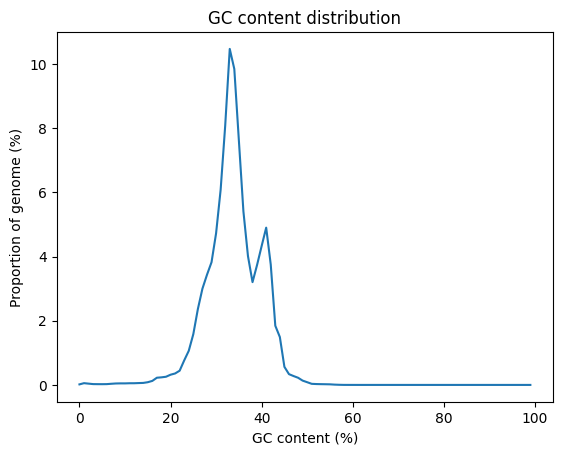

In [3]:
#Plot the GC content distribution
import matplotlib.pyplot as plt
plt.figure()
plt.plot(compositionGC['GC content(%)'], compositionGC['Proportion of genome(%)'])
plt.xlabel('GC content (%)')
plt.ylabel('Proportion of genome (%)')
#Add a 
plt.title('GC content distribution')

In [4]:
#Read the myGenome.txt file
myGenome =  open("../../data/OcculterCut/Occultercut_genome/myGenome.txt", "r")
myGenome = myGenome.read()

In [5]:
myGenome_df = pd.DataFrame()
myGenome_df['Region'] = [line.split('\t')[0] for line in myGenome.split('\n') if line.startswith('Region:')]
myGenome_df['Region'] = myGenome_df['Region'].str.replace('Region: ', '')
myGenome_df['Interval'] = [line.split('\t')[0] for line in myGenome.split('\n') if line.startswith('Interval_(%GC)')]
myGenome_df['Interval'] = myGenome_df['Interval'].str.replace('Interval_(%GC): ', '')
myGenome_df['Proportion of genome(%)'] = [line.split('\t')[0] for line in myGenome.split('\n') if line.startswith('Proportion_of_genome')]
myGenome_df['Proportion of genome(%)'] = myGenome_df['Proportion of genome(%)'].str.replace('Proportion_of_genome: ', '')
myGenome_df['Number_of_regions'] = [line.split('\t')[0] for line in myGenome.split('\n') if line.startswith('Number_of_regions')]
myGenome_df['Number_of_regions'] = myGenome_df['Number_of_regions'].str.split(':').str[1]


In [6]:
myGenome_df

,Region,Interval,Proportion of genome(%),Number_of_regions
0,R0,0->10,0.358,2766(2766)
1,R1,10->20,1.33,14101(14100)
2,R2,20->30,19.2,61801(61798)
3,R3,30->40,63.2,79087(79080)
4,R4,40->50,15.8,39546(39529)
5,R5,50->60,0.186,2105(2060)
6,R6,60->70,0.000366,7(7)
7,R7,70->80,0,0(0)
8,R8,80->90,0,0(0)
9,R9,90->100,0,0(0)


In [7]:
occultercut_genes = pd.read_table('../../data/OcculterCut/Occultercut_genome/groupedGenes.gff3', sep='\t', header =None)
occultercut_genes = occultercut_genes[occultercut_genes[2] == 'gene']
occultercut_genes[9] = occultercut_genes[8].str.split(';').str[0].str.split('.').str[1]
occultercut_genes =occultercut_genes.drop([5,7], axis=1)
occultercut_genes.columns = ['seqid', 'source', 'type', 'start', 'end', 'strand', 'attributes', 'Region']

In [8]:
occultercut_genes['seqid'] = occultercut_genes['seqid'].str.replace('AU3_HapA_CHR14ab', 'AU3_HapB_CHR14')
occultercut_genes['seqid'] = occultercut_genes['seqid'].apply(lambda x: x + 'A' if x.startswith('AU3_HapA') else x + 'B')
occultercut_genes['seqid'] = occultercut_genes['seqid'].str.split('_').str[2]
occultercut_genes['seqid'] = occultercut_genes['seqid'].str.replace('CHR', 'Chr')

In [9]:
occultercut_genes_count = occultercut_genes.groupby(['seqid', 'Region']).size().reset_index(name='Number_of_genes')

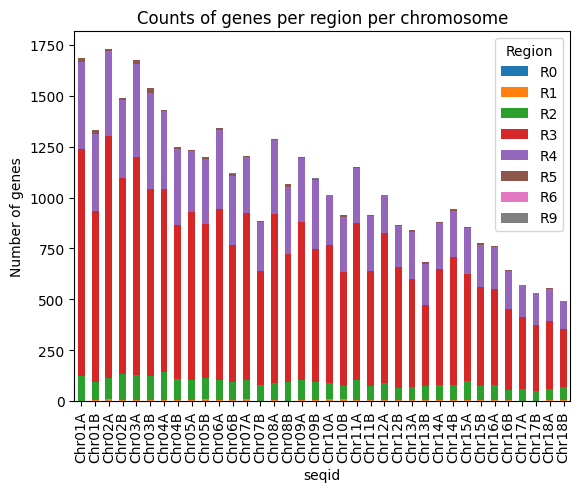

In [10]:
#plot the number of genes per seqid, stacked by region
occultercut_genes_count_pivot = occultercut_genes_count.pivot(index='seqid', columns='Region', values='Number_of_genes')
occultercut_genes_count_pivot = occultercut_genes_count_pivot.fillna(0)
occultercut_genes_count_pivot.plot(kind='bar', stacked=True)
plt.ylabel('Number of genes')
plt.title('Counts of genes per region per chromosome')
plt.show()

In [11]:
Au3_genome_hapA = list(SeqIO.parse('../../data/Au3_CHR_hapA_v3.fasta', 'fasta'))
Au3_genome_hapB = list(SeqIO.parse('../../data/Au3_CHR_hapB_v3.fasta', 'fasta'))
Au3_genome = Au3_genome_hapA + Au3_genome_hapB

Au3_genome_renamed = []
for seq in Au3_genome:
    seqid_old = seq.id
    seq_seq = seq.seq
    if '_ab' in seq.id:
        seqnew = 'Chr14B'
    elif 'HapA' in seqid_old:
        #Add A to the end of the chromosome name
        seqnew = seq.id + 'A'
        seqnew = seqnew.replace('APSI_AU3_HapA_CHR', 'Chr')
    elif 'HapB' in seqid_old:
        #Add B to the end of the chromosome name
        seqnew = seq.id + 'B'
        seqnew = seqnew.replace('APSI_AU3_HapB_CHR', 'Chr')
    Au3_genome_renamed.append(SeqRecord(seq=seq_seq, id=seqnew, name=seqid_old, description=''))


In [12]:
occultercut_regions = pd.read_table('../../data/OcculterCut/Occultercut_genome/groupedRegions.gff3', sep='\t', header =None)

In [13]:
occultercut_regions =occultercut_regions.drop([5,6,7], axis=1)
occultercut_regions.columns = ['seqid', 'source', 'type', 'start', 'end']
occultercut_regions['seqid'] = occultercut_regions['seqid'].str.replace('AU3_HapA_CHR14ab', 'AU3_HapB_CHR14')
occultercut_regions['seqid'] = occultercut_regions['seqid'].apply(lambda x: x + 'A' if x.startswith('AU3_HapA') else x + 'B')
occultercut_regions['seqid'] = occultercut_regions['seqid'].str.split('_').str[2]
occultercut_regions['seqid'] = occultercut_regions['seqid'].str.replace('CHR', 'Chr')


In [14]:
occultercut_regions_highGC = occultercut_regions[(occultercut_regions['type'] == 'R4_region') | (occultercut_regions['type'] == 'R5_region') | (occultercut_regions['type'] == 'R6_region')]

In [15]:
occultercut_regions_highGC

,seqid,source,type,start,end
4625,Chr08A,occult,R4_region,10133,11672
4626,Chr08A,occult,R4_region,94810,97218
4627,Chr08A,occult,R4_region,99991,104311
4628,Chr08A,occult,R4_region,148262,155871
4629,Chr08A,occult,R4_region,182561,197551
...,...,...,...,...,...
199408,Chr10B,occult,R5_region,53261482,53262823
199409,Chr10B,occult,R5_region,53794152,53796790
199410,Chr10B,occult,R5_region,54827754,54832337
199411,Chr10B,occult,R5_region,55057934,55059064


In [16]:
for item, row in occultercut_regions_highGC.iterrows():
    seqid = row['seqid']
    start = row['start']
    end = row['end']
    region_seq = ''
    for seq in Au3_genome_renamed:
        if seq.id == seqid:
            region_seq = seq.seq[start:end].upper()
            occultercut_regions_highGC.at[item, 'CpG'] = region_seq.count('CG')
            occultercut_regions_highGC.at[item, 'GpC'] = region_seq.count('GC')
            occultercut_regions_highGC.at[item, 'C'] = region_seq.count('C') 
            occultercut_regions_highGC.at[item, 'G'] = region_seq.count('G')

/tmp/ipykernel_2176/1432808425.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occultercut_regions_highGC.at[item, 'CpG'] = region_seq.count('CG')
/tmp/ipykernel_2176/1432808425.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occultercut_regions_highGC.at[item, 'GpC'] = region_seq.count('GC')
/tmp/ipykernel_2176/1432808425.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [17]:
occultercut_regions_highGC

,seqid,source,type,start,end,CpG,GpC,C,G
4625,Chr08A,occult,R4_region,10133,11672,16.0,63.0,406.0,255.0
4626,Chr08A,occult,R4_region,94810,97218,14.0,95.0,542.0,556.0
4627,Chr08A,occult,R4_region,99991,104311,125.0,250.0,904.0,1164.0
4628,Chr08A,occult,R4_region,148262,155871,15.0,288.0,1566.0,1674.0
4629,Chr08A,occult,R4_region,182561,197551,193.0,643.0,3404.0,3051.0
...,...,...,...,...,...,...,...,...,...
199408,Chr10B,occult,R5_region,53261482,53262823,93.0,59.0,267.0,474.0
199409,Chr10B,occult,R5_region,53794152,53796790,89.0,245.0,1102.0,381.0
199410,Chr10B,occult,R5_region,54827754,54832337,285.0,320.0,1135.0,1274.0
199411,Chr10B,occult,R5_region,55057934,55059064,76.0,80.0,215.0,405.0


In [86]:
test_seq = [seq for seq in Au3_genome_renamed if seq.id == 'Chr10B'][0][55499220:55509584]

In [93]:
test_seq.seq.upper().count('G')

5190

In [21]:
mCpG = pd.read_table('../../data/Methylation/Au3_5mCpG_filtered.bed', sep='\t', header=None, comment='#')
mCpG.columns = ['Chr', 'Start', 'End', 'per', 'depth']
mCpG_bed = mCpG[['Chr', 'Start', 'End']]
mCpG_bed['Chr'] = mCpG_bed['Chr'].astype(str)
mCpG_bed['Start'] = mCpG_bed['Start'].astype(int)
mCpG_bed['End'] = mCpG_bed['End'].astype(int)
mCpG_bed['Chr'] = mCpG_bed['Chr'].str.replace('CHR', 'Chr')
mCpG_bed= pybedtools.BedTool.from_dataframe(mCpG_bed) 

/tmp/ipykernel_2176/1423155518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mCpG_bed['Chr'] = mCpG_bed['Chr'].astype(str)
/tmp/ipykernel_2176/1423155518.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mCpG_bed['Start'] = mCpG_bed['Start'].astype(int)
/tmp/ipykernel_2176/1423155518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [22]:
CG_bed = occultercut_regions_highGC[['seqid','start','end']]
CG_bed = pybedtools.BedTool.from_dataframe(CG_bed)

In [23]:
CG_m5CpG_intersect = CG_bed.intersect(mCpG_bed, wa=True, wb=True)

***** WARNING: File /tmp/pybedtools.0p7o281o.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.0p7o281o.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512



In [ ]:
CG_m5CpG_intersect = CG_m5CpG_intersect.to_dataframe()

In [30]:
CG_m5CpG_intersect_df = CG_m5CpG_intersect.groupby(['chrom', 'start', 'end']).count().reset_index()
CG_m5CpG_intersect_df = CG_m5CpG_intersect_df[['chrom', 'start', 'end', 'name']]
CG_m5CpG_intersect_df.columns = ['chrom', 'start', 'end', 'm5CpG_count']

In [32]:
occultercut_regions_highGC

,seqid,source,type,start,end,CpG,GpC,C,G
4625,Chr08A,occult,R4_region,10133,11672,16.0,63.0,406.0,255.0
4626,Chr08A,occult,R4_region,94810,97218,14.0,95.0,542.0,556.0
4627,Chr08A,occult,R4_region,99991,104311,125.0,250.0,904.0,1164.0
4628,Chr08A,occult,R4_region,148262,155871,15.0,288.0,1566.0,1674.0
4629,Chr08A,occult,R4_region,182561,197551,193.0,643.0,3404.0,3051.0
...,...,...,...,...,...,...,...,...,...
199408,Chr10B,occult,R5_region,53261482,53262823,93.0,59.0,267.0,474.0
199409,Chr10B,occult,R5_region,53794152,53796790,89.0,245.0,1102.0,381.0
199410,Chr10B,occult,R5_region,54827754,54832337,285.0,320.0,1135.0,1274.0
199411,Chr10B,occult,R5_region,55057934,55059064,76.0,80.0,215.0,405.0


In [35]:
CG_m5CpG_intersect_df0 = CG_m5CpG_intersect_df.merge(occultercut_regions_highGC, left_on=['chrom', 'start', 'end'], right_on=['seqid', 'start', 'end'], how='outer')
#Fill the NaN values in chrom with the seqid, and the NaN values in m5CpG_count with 0
CG_m5CpG_intersect_df0['chrom'] = CG_m5CpG_intersect_df0['chrom'].fillna(CG_m5CpG_intersect_df0['seqid'])
CG_m5CpG_intersect_df0['m5CpG_count'] = CG_m5CpG_intersect_df0['m5CpG_count'].fillna(0)

In [37]:
CG_m5CpG_intersect_df0['mCpG/CG'] = CG_m5CpG_intersect_df0['m5CpG_count']/CG_m5CpG_intersect_df0['CpG']

In [40]:
CG_m5CpG_intersect_df0[CG_m5CpG_intersect_df0['type'] == 'R6_region']

,chrom,start,end,m5CpG_count,seqid,source,type,CpG,GpC,C,G,mCpG/CG
2047,Chr01B,11036876,11037930,73.0,Chr01B,occult,R6_region,78.0,52.0,133.0,555.0,0.935897
2259,Chr01B,18468482,18469508,34.0,Chr01B,occult,R6_region,50.0,116.0,480.0,147.0,0.680000
11703,Chr04B,2537405,2538485,92.0,Chr04B,occult,R6_region,93.0,59.0,155.0,571.0,0.989247
18752,Chr07A,14375268,14376546,73.0,Chr07A,occult,R6_region,76.0,48.0,131.0,651.0,0.960526
21992,Chr08A,49531016,49532034,0.0,Chr08A,occult,R6_region,85.0,110.0,298.0,315.0,0.000000
23272,Chr08B,48684746,48685759,0.0,Chr08B,occult,R6_region,82.0,107.0,300.0,308.0,0.000000
25295,Chr09B,34947674,34948732,79.0,Chr09B,occult,R6_region,81.0,49.0,132.0,544.0,0.975309
